In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from airborne_risk import \
    INFECTOR_ACTIVITY_TO_FACTOR, \
    activity_to_met, \
    average_m_f_co2_generation_rate, \
    average_event_risk_tolerance, \
    compute_risk_assuming_infector_is_present, \
    covid_risk_budget_within_months, \
    probability_that_someone_is_infectious_in_room, \
    remaining_risk_budget, \
    steady_state_co2_level, \
    wastewater_to_proba_infectious, \
    ventilation_cadr_m3_h

In [2]:
covid_risk_budget_within_months()

0.017552379283172215

In [3]:
average_event_risk_tolerance(risk_budget=covid_risk_budget_within_months())

0.0007375715647440773

Looks like microCOVID sums up to the risk budget:

In [4]:
average_event_risk_tolerance(risk_budget=covid_risk_budget_within_months()) * 24

0.017701717553857854

In [5]:
def event_risk_tolerance(
    half_years=120, 
    long_covid_risk_per_infection=0.06, 
    long_covid_risk_tolerance_for_half_years=0.15, 
    number_of_events_per_half_year=12):

    numerator = 1  - (1-long_covid_risk_tolerance_for_half_years) ** (1. / half_years)
    denominator = 1 - long_covid_risk_per_infection
    
    return 1 - (1 - numerator / denominator) ** (1. / number_of_events_per_half_year)

In [6]:
probability_that_someone_is_infectious_in_room(occupancy=5, proba_infectious=np.array([0.1, 0.05]))

array([0.40951   , 0.22621906])

In [10]:
wastewater_to_proba_infectious(200)

0.004347826086956522

In [11]:
ventilation_cadr_m3_h( 
    steady_state_co2_ppm=1900, 
    co2_generation_rate=average_m_f_co2_generation_rate(
        activity_to_met("Sitting reading, writing, typing"), 
        occupancy=3
    )
)

30.702648648648648

In [12]:
steady_state_co2_level(ventilation_cadr=30.7, co2_generation_rate=average_m_f_co2_generation_rate(
        activity_to_met("Sitting reading, writing, typing"), 
        occupancy=3
    )
                      )

1900.127687296417

In [16]:
compute_risk_assuming_infector_is_present(
    exhalation_activity_factor=INFECTOR_ACTIVITY_TO_FACTOR["Resting – Speaking"],
    cadr_m3_per_hour=ventilation_cadr_m3_h( 
        steady_state_co2_ppm=600, 
        co2_generation_rate=average_m_f_co2_generation_rate(
            activity_to_met("Sitting reading, writing, typing"), 
            occupancy=20
        )
    )
) * probability_that_someone_is_infectious_in_room(occupancy=20, proba_infectious=wastewater_to_proba_infectious(1000))

0.016668720129466363

In [14]:
remaining_risk_budget(total_risk_budget=0.01, risks=np.array([0.001]))

0.009009009009009028

In [15]:
remaining_risk_budget(total_risk_budget=0.01, risks=np.array([0.02]))

UserError: Budget exceeded!

In [38]:
proportion_infectious = wastewater_to_proba_infectious(200)

In [39]:
risk_tolerance_for_event = event_risk_tolerance()

In [40]:
risk_tolerance_for_event

0.00012006220511429078

In [41]:
probability_that_someone_is_infectious_in_room(occupancy=20, proba_infectious=proportion_infectious)

0.08345682787094022

In [42]:
risk_tolerance_for_event_assuming_at_least_one_infectious_person = risk_tolerance_for_event / probability_that_someone_is_infectious_in_room(occupancy=30, proba_infectious=proportion_infectious)

In [43]:
risk_tolerance_for_event_assuming_at_least_one_infectious_person

0.0009798130154025236

In [44]:
compute_risk_assuming_infector_is_present(time_hours=1, susceptible_mask_exposure_reduction_factor=36, cadr_m3_per_hour=600)

0.0007953502078819064

In [45]:
compute_risk_assuming_infector_is_present(time_hours=1, susceptible_mask_exposure_reduction_factor=10, cadr_m3_per_hour=800)

0.002145994055137712

How many risky events are you planning to take every 6 months?

What is the wastewater level currently (100 - 11500)?
- What combination of the following are acceptable?
  - occupancy (1,5, 10, 20, 30, 40, 50, 100, 150, 200)
  - time (1, 2, 4, 8, 12)
  - infector masking: none (1), N95 with leaks (10), N95 fitted (100)
  - susceptible masking: none (1), N95 with leaks (10), N95 fitted (100)h
  - susceptible personal air cleaner: none, LaminAir (36)
  - CO2 reading (420, 430, ..., 4990, 5000)
  - Room filtration (0, 100, 200, ..., 2000)

In [46]:
MASKING_ERF = {
    'Unmasked': 1,
    'N95 with leaks': 10,
    'N95 no leaks': 100,
}

PERSONAL_AIR_CLEANING_ERF = {
    'None': 1,
    'LaminAir at 12 inches': 36,
    'SmartAir QT3 at 12 inches': 2.5
}

In [55]:
PERSONAL_AIR_CLEANING_ERF.keys()

dict_keys(['None', 'LaminAir at 12 inches', 'SmartAir QT3 at 12 inches'])

In [247]:
def combinations(
    occupancies=None,
    durations=None,
    infector_maskings=None,
    susceptible_maskings=None,
    susceptible_personal_air_cleaning_devices=None,
    age='30 to <40',
    ventilation_rate=None,
    filtration_rate=None
    
):
    if occupancies is None:
        occupancies = [1,5, 10, 20, 30, 40, 50, 100, 150, 200]

    if durations is None:
        durations = [1,2,4,8,12,24]

    if infector_maskings is None:
        infector_maskings = MASKING_ERF.keys()

    if susceptible_maskings is None:
        susceptible_maskings = MASKING_ERF.keys()

    if susceptible_personal_air_cleaning_devices is None:
        susceptible_personal_air_cleaning_devices = PERSONAL_AIR_CLEANING_ERF.keys()

    if ventilation_rate is None:
        ventilation_rate = list(range(1, 2000, 100))
        
    if filtration_rate is None:
        filtration_rate = list(range(1, 2000, 100))

    
    possible_combos = itertools.product(
        occupancies, 
        durations, 
        infector_maskings, 
        susceptible_maskings, 
        susceptible_personal_air_cleaning_devices,
        ventilation_rate,
        filtration_rate
    )
    
    return pd.DataFrame(
        data=possible_combos,
        columns=['occupancy', 'duration', 'infector_mask', 'susceptible_mask', 'susceptible_personal_air_cleaner', 'ventilation_rate (m3/h)', 'filtration_rate (m3/h)']
    )

In [248]:
combos = combinations()

In [249]:
combos

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h)
0,1,1,Unmasked,Unmasked,None,1,1
1,1,1,Unmasked,Unmasked,None,1,101
2,1,1,Unmasked,Unmasked,None,1,201
3,1,1,Unmasked,Unmasked,None,1,301
4,1,1,Unmasked,Unmasked,None,1,401
...,...,...,...,...,...,...,...
647995,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1501
647996,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1601
647997,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1701
647998,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1801


In [250]:
column_to_erf_mappings = {
    'infector_mask': MASKING_ERF,
    'susceptible_mask': MASKING_ERF,
    'susceptible_personal_air_cleaner': PERSONAL_AIR_CLEANING_ERF
}

In [251]:
for col in column_to_erf_mappings:
    combos[f'{col}_erf'] = combos[f'{col}'].apply(lambda x: column_to_erf_mappings[col][x]) 


In [252]:
combos

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h),infector_mask_erf,susceptible_mask_erf,susceptible_personal_air_cleaner_erf
0,1,1,Unmasked,Unmasked,None,1,1,1,1,1.0
1,1,1,Unmasked,Unmasked,None,1,101,1,1,1.0
2,1,1,Unmasked,Unmasked,None,1,201,1,1,1.0
3,1,1,Unmasked,Unmasked,None,1,301,1,1,1.0
4,1,1,Unmasked,Unmasked,None,1,401,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...
647995,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1501,100,100,2.5
647996,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1601,100,100,2.5
647997,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1701,100,100,2.5
647998,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1801,100,100,2.5


In [253]:
combos['susceptible_personal_air_cleaner_erf'].unique()

array([ 1. , 36. ,  2.5])

In [254]:
def get_steady_state_co2_level(row):
    
    co2_generation_rate =  average_m_f_co2_generation_rate(activity_to_met("Sitting tasks, light effort (e.g, office work)")) * LITERS_PER_SECOND_TO_CUBIC_METERS_PER_HOUR
    
    return steady_state_co2_level(occupancy=row['occupancy'], ventilation_cadr=row['ventilation_rate (m3/h)'], co2_generation_rate=co2_generation_rate)

In [255]:
combos['steady_state_co2'] = combos.apply(get_steady_state_co2_level, axis=1)

In [256]:
combos

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h),infector_mask_erf,susceptible_mask_erf,susceptible_personal_air_cleaner_erf,steady_state_co2
0,1,1,Unmasked,Unmasked,None,1,1,1,1,1.0,17908.800000
1,1,1,Unmasked,Unmasked,None,1,101,1,1,1.0,17908.800000
2,1,1,Unmasked,Unmasked,None,1,201,1,1,1.0,17908.800000
3,1,1,Unmasked,Unmasked,None,1,301,1,1,1.0,17908.800000
4,1,1,Unmasked,Unmasked,None,1,401,1,1,1.0,17908.800000
...,...,...,...,...,...,...,...,...,...,...,...
647995,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1501,100,100,2.5,2259.957917
647996,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1601,100,100,2.5,2259.957917
647997,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1701,100,100,2.5,2259.957917
647998,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1801,100,100,2.5,2259.957917


In [257]:
combos.columns

Index(['occupancy', 'duration', 'infector_mask', 'susceptible_mask',
       'susceptible_personal_air_cleaner', 'ventilation_rate (m3/h)',
       'filtration_rate (m3/h)', 'infector_mask_erf', 'susceptible_mask_erf',
       'susceptible_personal_air_cleaner_erf', 'steady_state_co2'],
      dtype='object')

In [258]:
combos['infection_risk_assuming_1_infector'] = combos.apply(
    lambda r: compute_risk_assuming_infector_is_present(
        cadr_m3_per_hour=r['ventilation_rate (m3/h)'] + r['filtration_rate (m3/h)'],
        susceptible_mask_exposure_reduction_factor=r['susceptible_mask_erf'] * r['susceptible_personal_air_cleaner_erf'],
        infector_mask_exposure_reduction_factor=r['infector_mask_erf'],
        inhalation_factor=1,
        exhalation_activity_factor=1,
        time_hours=r['duration']
    ),
    axis=1
)

In [259]:
combos

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h),infector_mask_erf,susceptible_mask_erf,susceptible_personal_air_cleaner_erf,steady_state_co2,infection_risk_assuming_1_infector
0,1,1,Unmasked,Unmasked,None,1,1,1,1,1.0,17908.800000,0.999815
1,1,1,Unmasked,Unmasked,None,1,101,1,1,1.0,17908.800000,0.155064
2,1,1,Unmasked,Unmasked,None,1,201,1,1,1.0,17908.800000,0.081562
3,1,1,Unmasked,Unmasked,None,1,301,1,1,1.0,17908.800000,0.055320
4,1,1,Unmasked,Unmasked,None,1,401,1,1,1.0,17908.800000,0.041851
...,...,...,...,...,...,...,...,...,...,...,...,...
647995,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1501,100,100,2.5,2259.957917,0.000005
647996,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1601,100,100,2.5,2259.957917,0.000005
647997,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1701,100,100,2.5,2259.957917,0.000005
647998,200,24,N95 no leaks,N95 no leaks,SmartAir QT3 at 12 inches,1901,1801,100,100,2.5,2259.957917,0.000004


In [269]:
risk_tolerance_per_event = event_risk_tolerance(number_of_events_per_half_year=1)

In [270]:
def possibilities_with_proba_infectious_present(wastewater_level, combos):
    copy = combos.copy()
    copy['proba_infectious_present'] = combos.apply(
        lambda r: probability_that_someone_is_infectious_in_room(
            occupancy=r['occupancy'], 
            proba_infectious=wastewater_to_proba_infectious(wastewater_level)
        ),
        axis=1
    )
    return copy

    

In [271]:
def combos_that_satisfy_risk_tolerance_per_event(
    risk_tolerance_per_event,
    wastewater_level,
    combos
):
    """
    Parameters:
        risk_tolerance_per_event: float
            The risk that can be tolerated for one event.

        wastewater_level: float
            RNA copies / mL: https://www.mwra.com/biobot/biobotdata.htm

        combos: pd.DataFrame
            Combination of different options. Has the following columns
    """
    
    copy = possibilities_with_proba_infectious_present(wastewater_level=wastewater_level, combos=combos)
    copy['total_event_risk'] = copy['proba_infectious_present'] * copy['infection_risk_assuming_1_infector']
    return copy[copy['total_event_risk'] < risk_tolerance_per_event]

## When we want to be unmasked with people, and we assume that there is no filtration, and there is no personal air cleaner (e.g. LaminAir), what environmental controls should we expect? 

Below, we display the corresponding CO2 max limit (or equivalent ventilation rate) for a given occupancy and duration:

In [297]:
risk_per_event_mapping = {
    '6': event_risk_tolerance(number_of_events_per_half_year=6),
    '12': event_risk_tolerance(number_of_events_per_half_year=12)
}

risk_per_event_mapping

{'6': 0.00024010999529555654, '12': 0.00012006220511429078}

In [298]:
graphs = [
    {
        'suptitle': "6 events in half a year: No masking, no personal air cleaning",
        'filter': lambda df: (df['susceptible_mask'] == 'Unmasked') & \
            (df['infector_mask'] == 'Unmasked') & \
            (df['filtration_rate (m3/h)'] == 1) & \
            (df['susceptible_personal_air_cleaner'] == 'None'),
        'risk_tolerance_per_event': risk_per_event_mapping['6']
    },
    {
        'suptitle': "6 events in half a year: No masking, with LaminAir at 12 inches",
        'filter': lambda df: (df['susceptible_mask'] == 'Unmasked') & \
            (df['infector_mask'] == 'Unmasked') & \
            (df['filtration_rate (m3/h)'] == 1) & \
            (df['susceptible_personal_air_cleaner'] == 'LaminAir at 12 inches'),
        'risk_tolerance_per_event': risk_per_event_mapping['6']
    },
    {
        'suptitle': "6 events in half a year: N95 masking with susceptible, no personal air cleaning",
        'filter': lambda df: (df['susceptible_mask'] == 'N95 no leaks') & \
            (df['infector_mask'] == 'Unmasked') & \
            (df['susceptible_personal_air_cleaner'] == 'None') &\
            (df['filtration_rate (m3/h)'] == 1),
        'risk_tolerance_per_event': risk_per_event_mapping['6']
    },
    {
        'suptitle': "12 events in half a year: No masking, no personal air cleaning",
        'filter': lambda df: (df['susceptible_mask'] == 'Unmasked') & \
            (df['infector_mask'] == 'Unmasked') & \
            (df['filtration_rate (m3/h)'] == 1) & \
            (df['susceptible_personal_air_cleaner'] == 'None'),
        'risk_tolerance_per_event': risk_per_event_mapping['12']
    },
    {
        'suptitle': "12 events in half a year: No masking, with LaminAir at 12 inches",
        'filter': lambda df: (df['susceptible_mask'] == 'Unmasked') & \
            (df['infector_mask'] == 'Unmasked') & \
            (df['filtration_rate (m3/h)'] == 1) & \
            (df['susceptible_personal_air_cleaner'] == 'LaminAir at 12 inches'),
        'risk_tolerance_per_event': risk_per_event_mapping['12']
    },
    {
        'suptitle': "12 events in half a year: N95 masking with susceptible, no personal air cleaning",
        'filter': lambda df: (df['susceptible_mask'] == 'N95 no leaks') & \
            (df['infector_mask'] == 'Unmasked') & \
            (df['susceptible_personal_air_cleaner'] == 'None') &\
            (df['filtration_rate (m3/h)'] == 1),
        'risk_tolerance_per_event': risk_per_event_mapping['12']
    }
]

In [299]:
def plot_graph(graph_data, figsize=None):
    if figsize is None:
        figsize = (20,5)
    fig, ax = plt.subplots(1,4, figsize=figsize)
    for i, wastewater_level in enumerate([250, 1000, 1500, 3000]):    
        satisfied = combos_that_satisfy_risk_tolerance_per_event(
            risk_tolerance_per_event=graph_data['risk_tolerance_per_event'],
            wastewater_level=wastewater_level,
            combos=combos
        )
    
        filtered = satisfied[
            graph_data['filter'](satisfied)
        ].groupby(['occupancy', 'duration']).agg({'steady_state_co2': [ 'max'], 'ventilation_rate (m3/h)': ['min']})

        
        ax[i].set_title(f"Wastewater level: {wastewater_level} RNA copies / mL")
        
        if filtered.shape[0] == 0:
            continue
            
        sns.heatmap(
            filtered,
            annot=True,
            fmt=".0f",
            ax=ax[i]
        )
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    
    fig.suptitle(graph_data['suptitle'])
    fig.tight_layout()
        
   

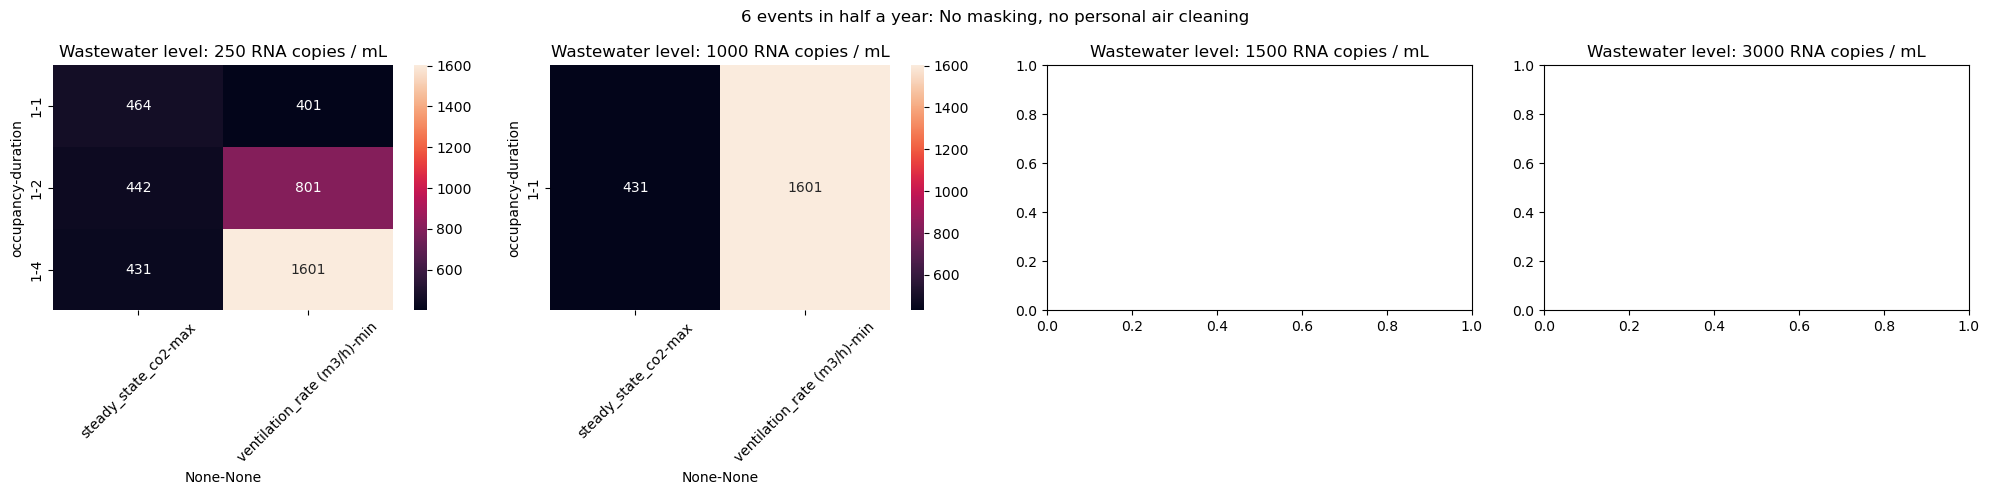

In [300]:
plot_graph(graphs[0])

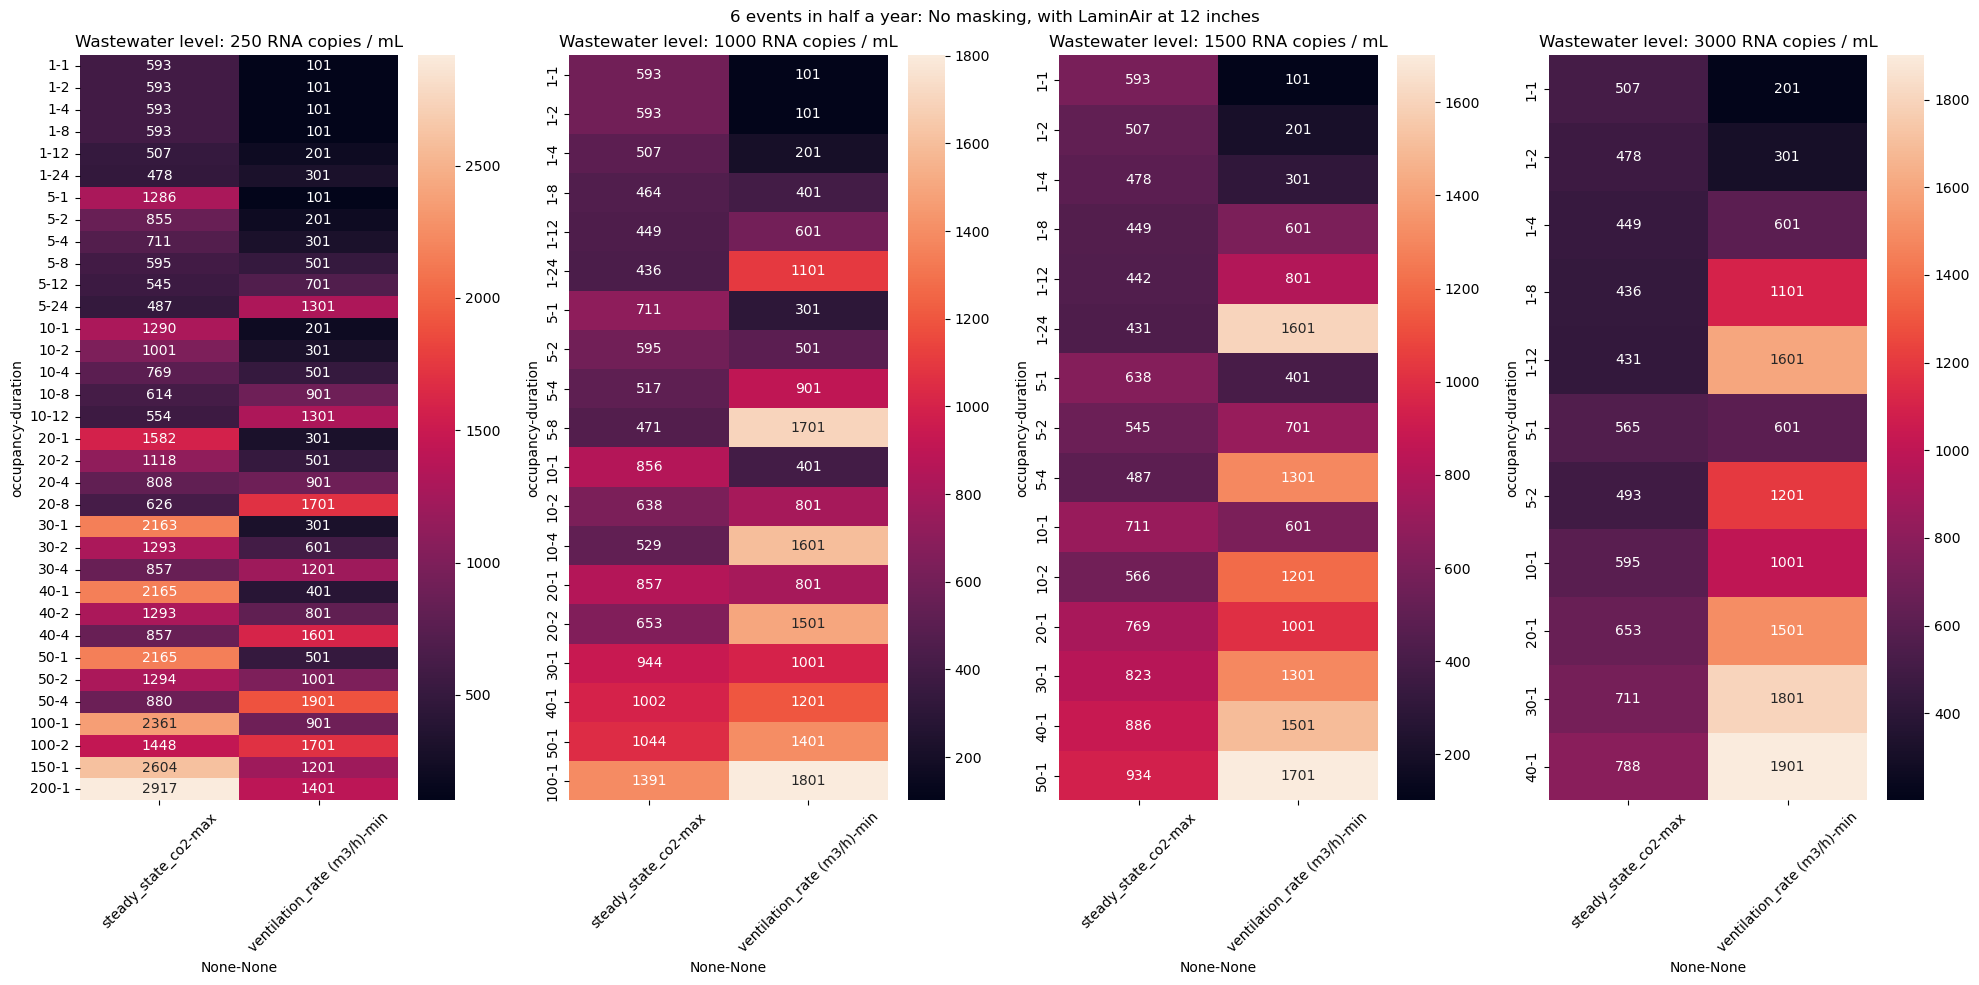

In [301]:
plot_graph(graphs[1], figsize=(20,10))

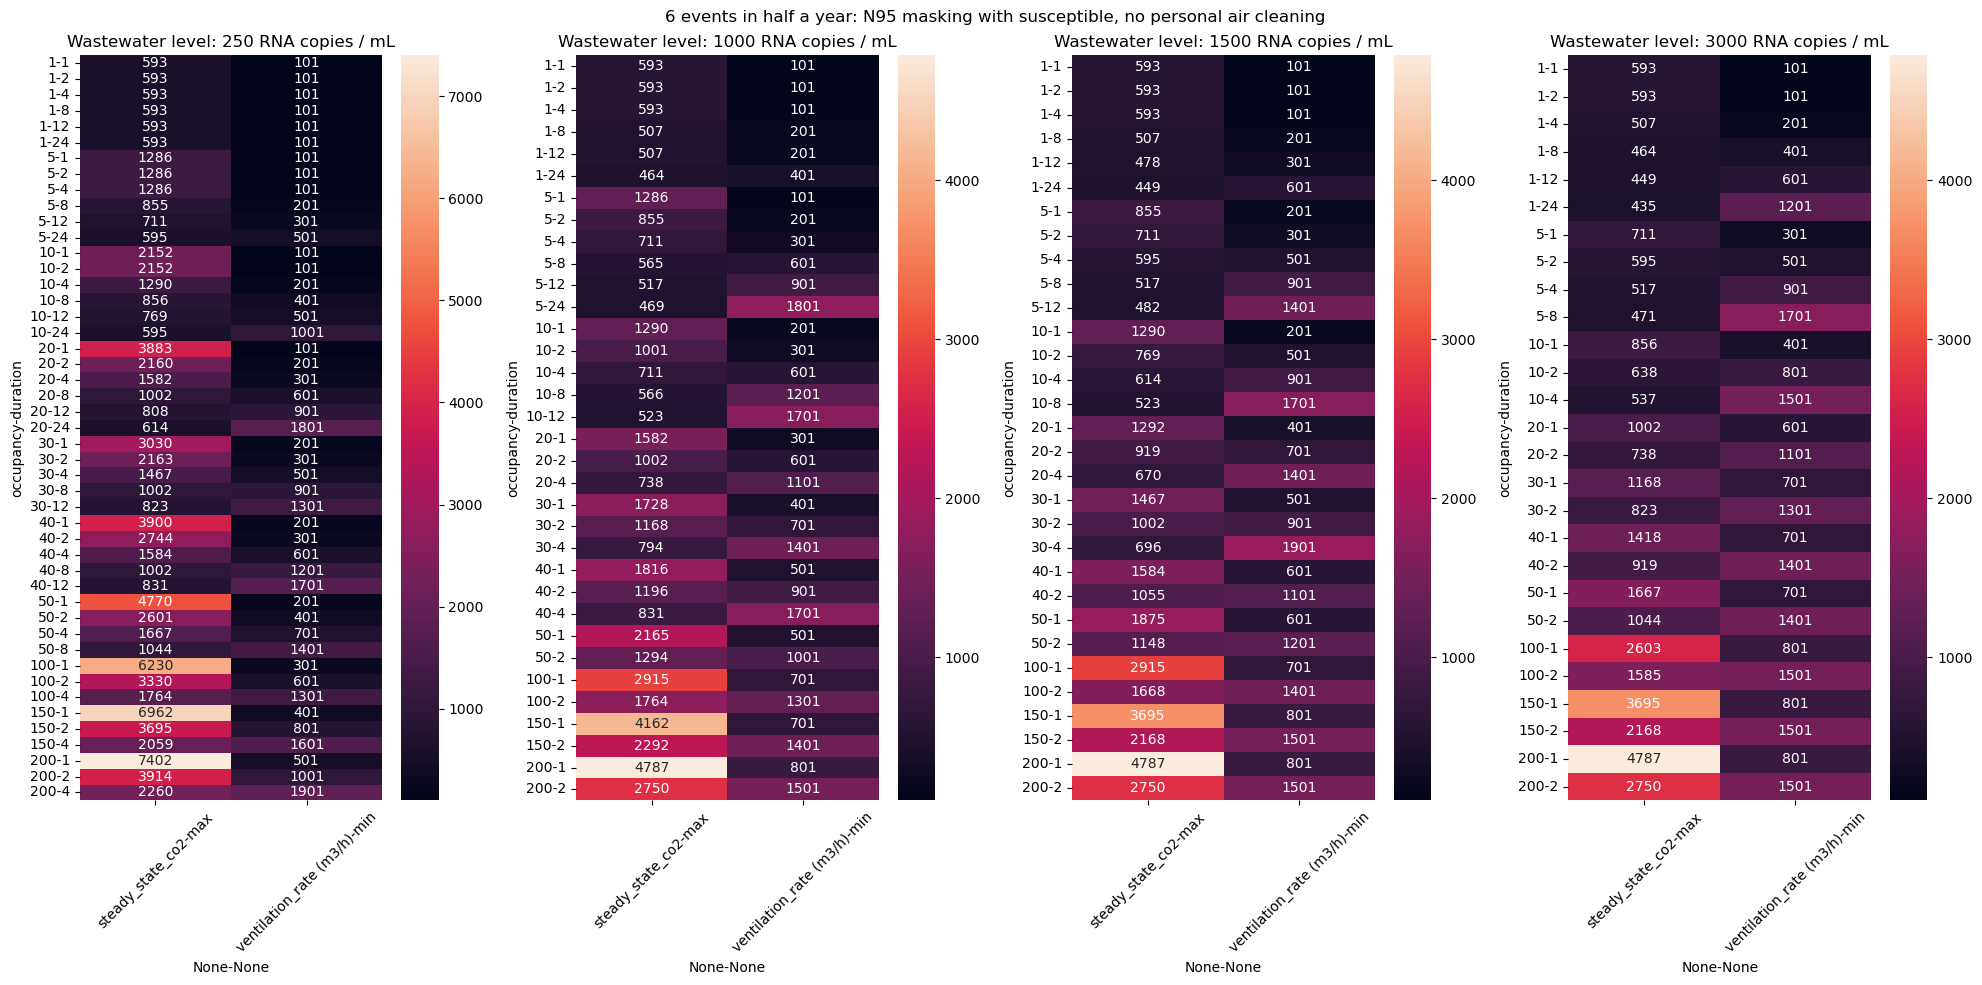

In [302]:
plot_graph(graphs[2], figsize=(20,10))

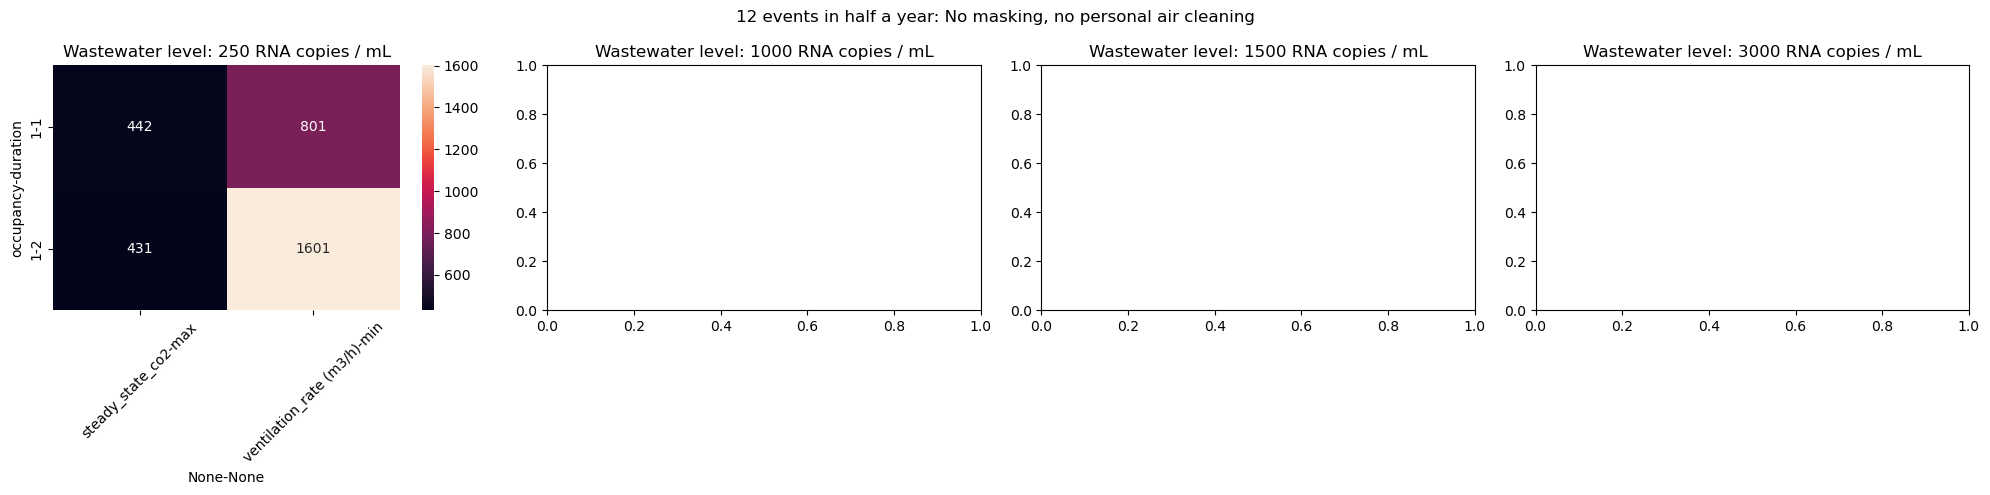

In [303]:
plot_graph(graphs[3], figsize=(20,5))

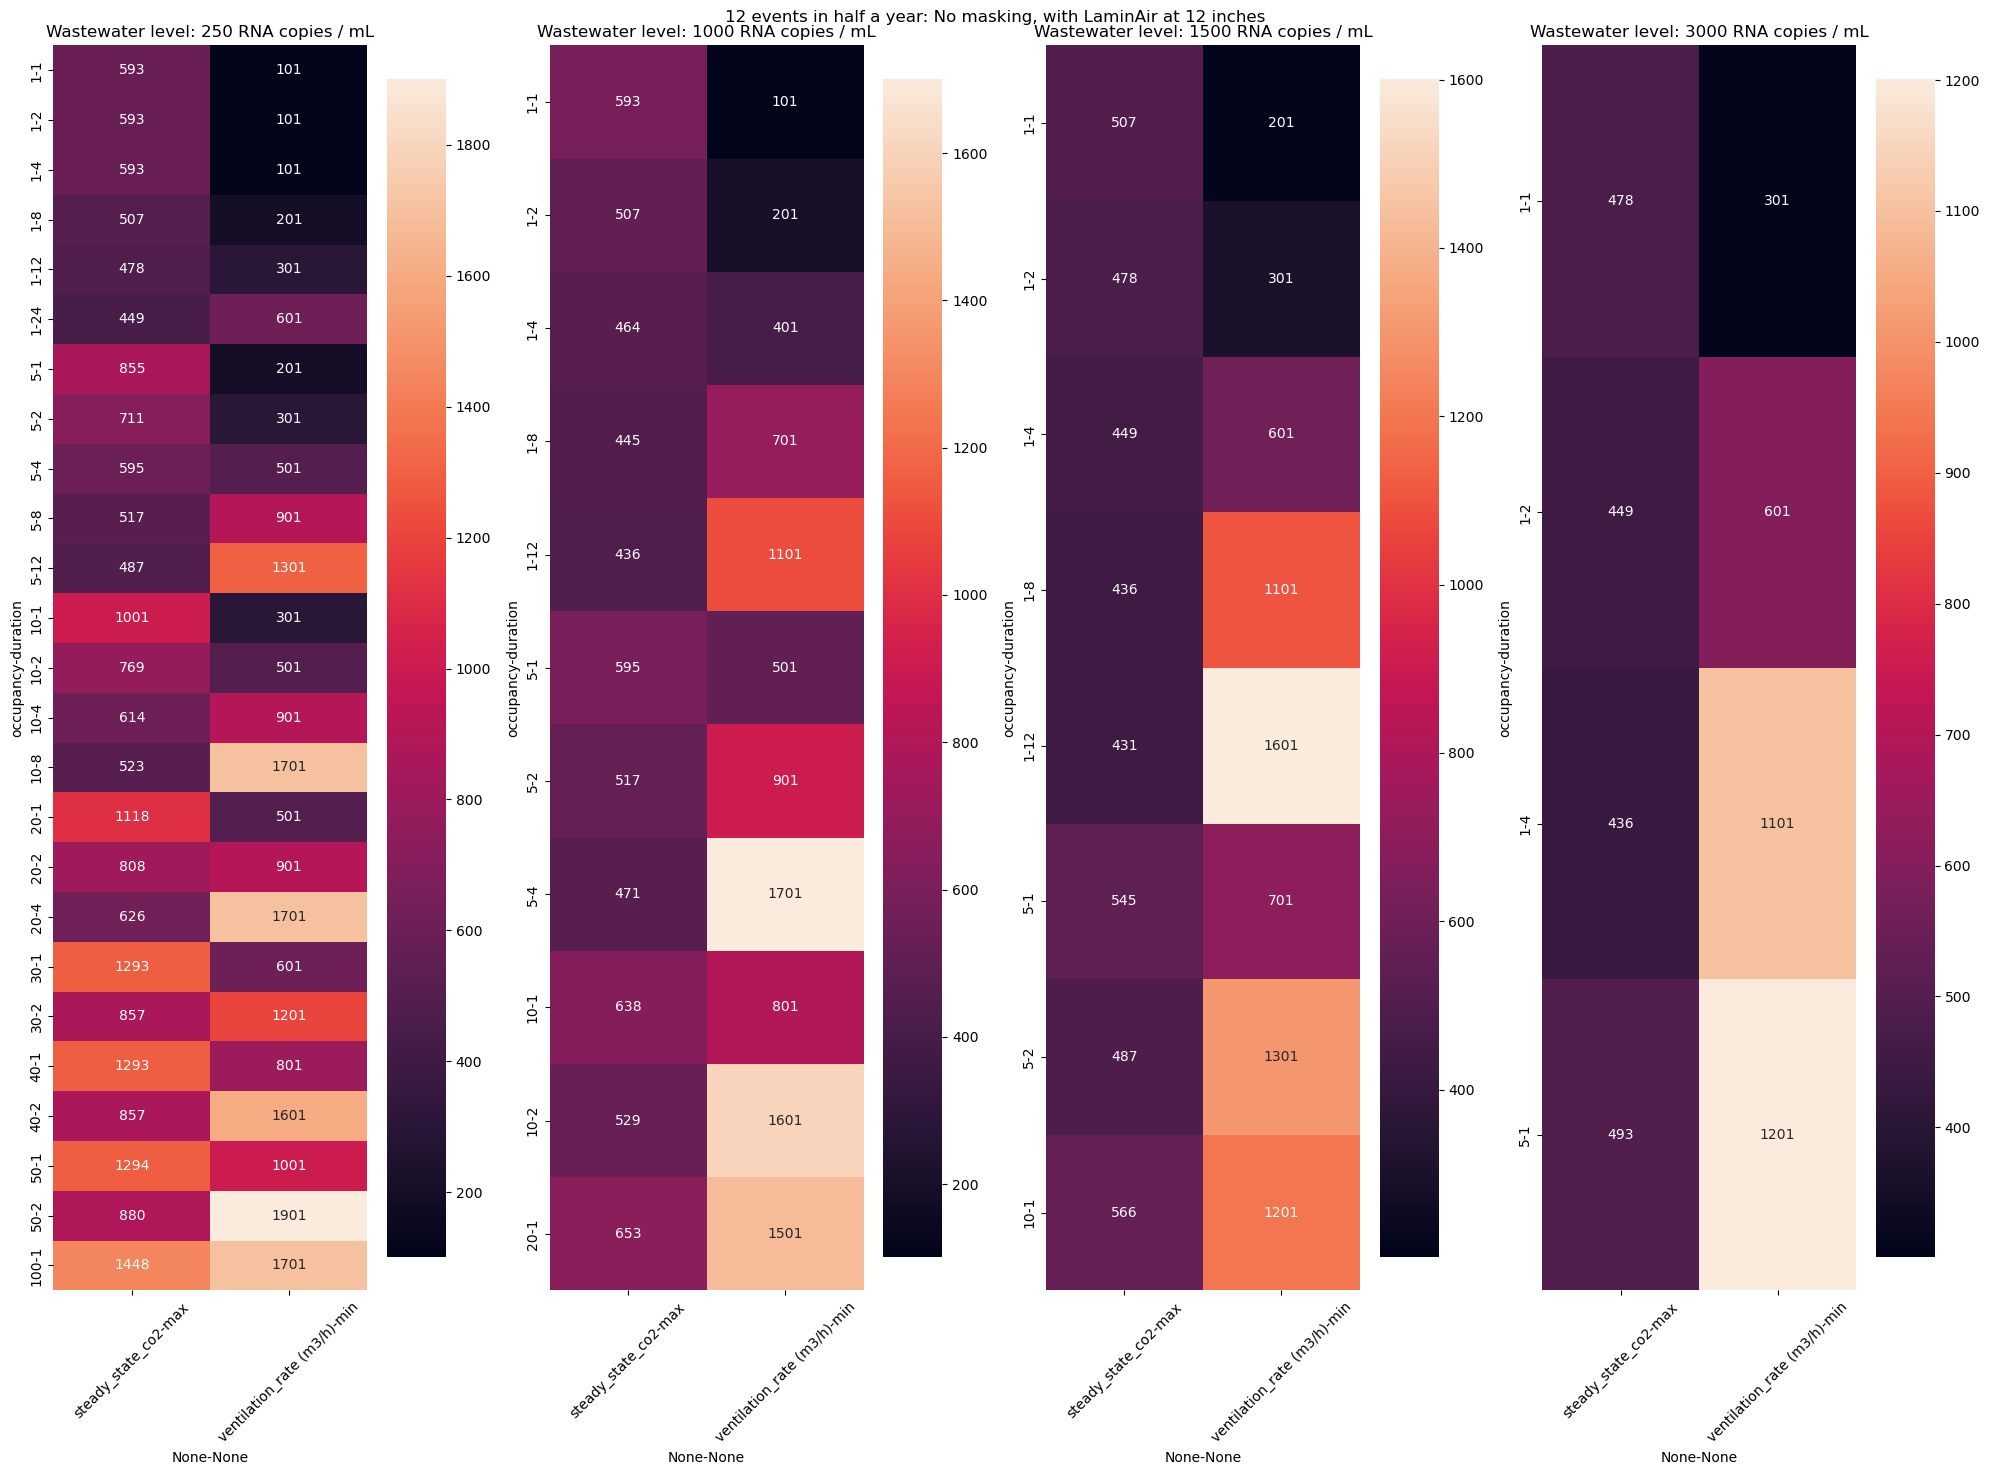

In [304]:
plot_graph(graphs[4], figsize=(20,15))

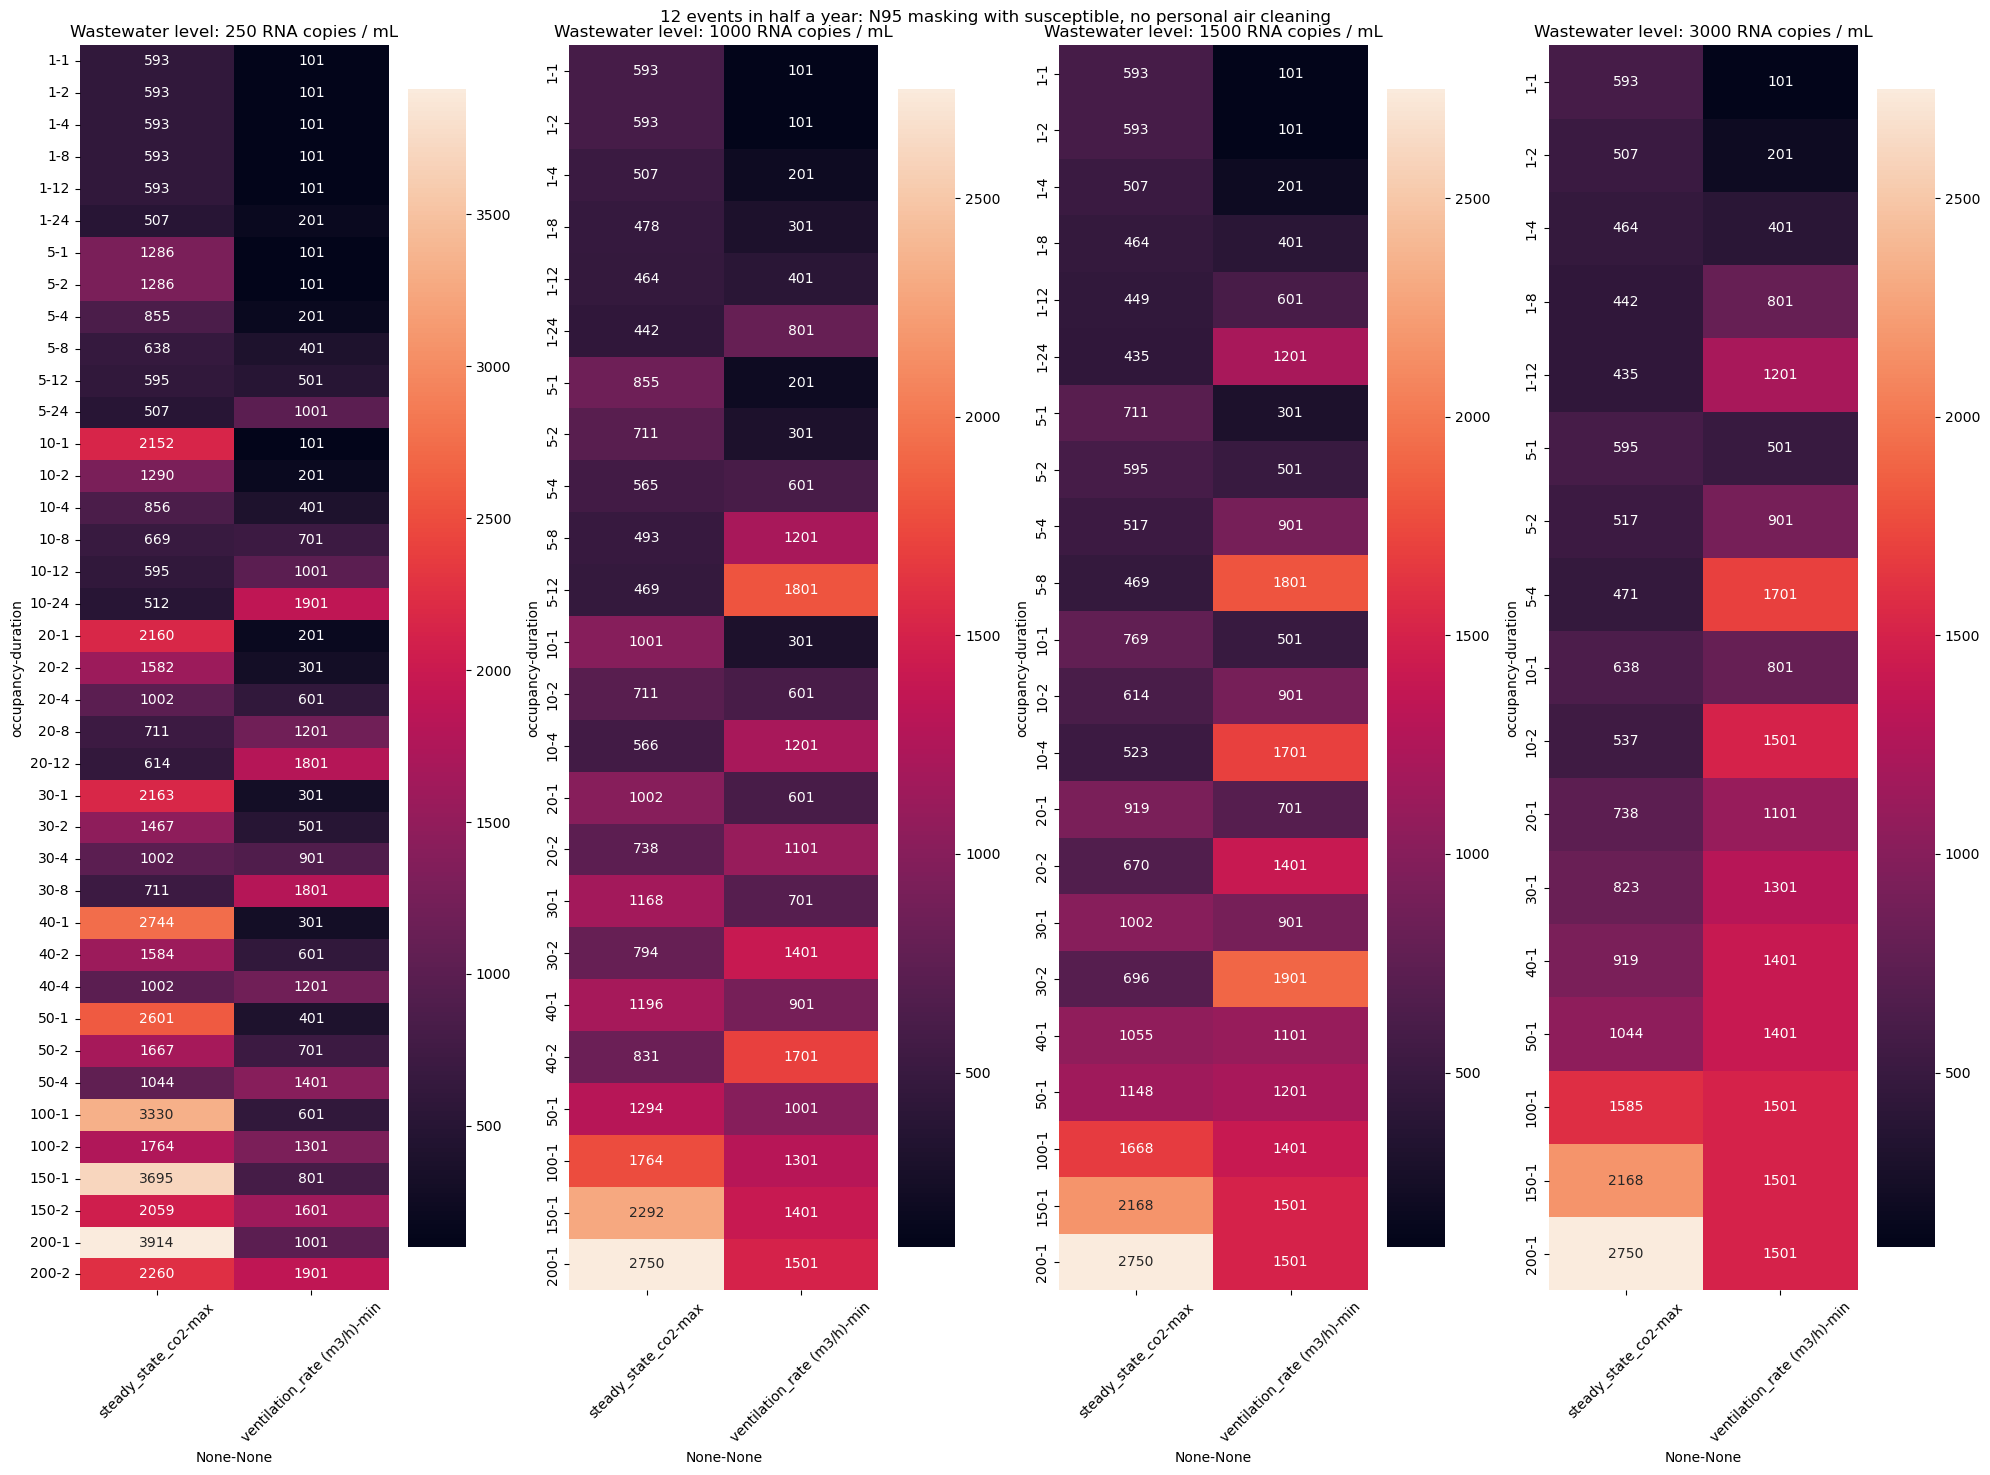

In [305]:
plot_graph(graphs[5], figsize=(20,15))

### Ex: If occupancy is 1, duration is 1 hour, and steady state CO2 max is 463, and the ventilation rate (m3/h) is 401.

This tells us that for that given occupancy and duration, having a steady state CO2 of 463 or below satisfies the risk tolerance.

However, if CO2 levels aren't available, but you have full control about supplementing the ventilation with filtration, you can use the equivalent ventilation rate for filtration (e.g. adding 401 m3/h of filtration will satisfy the risk tolerance)

## When we want to be unmasked with people, and we assume that there is no filtration, but we do have a personal air cleaner (e.g. LaminAir), what environmental controls should we expect? 

Again, we display the corresponding CO2 max limit (or equivalent ventilation rate) for a given occupancy and duration:

Text(0.5, 1.0, 'CO2-related Limits Given Occupancy and Duration')

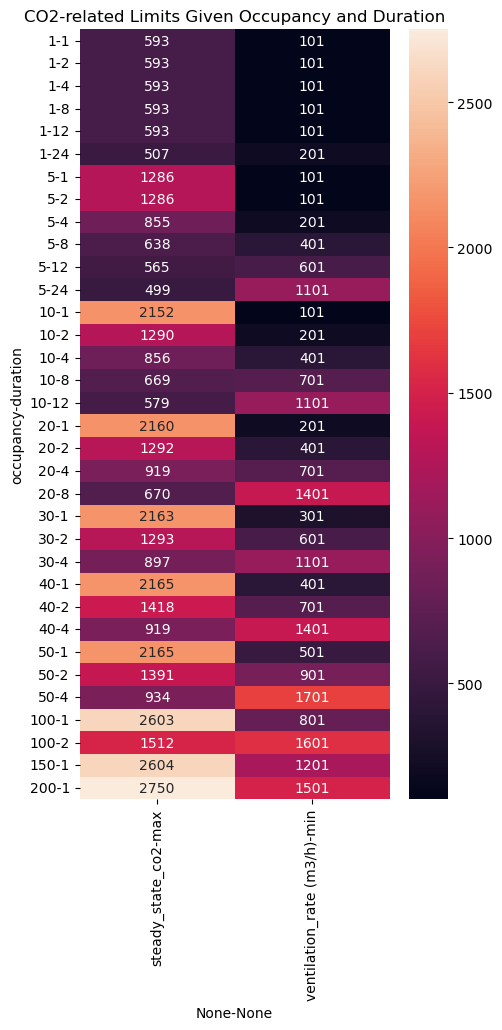

In [175]:
fig, ax = plt.subplots(1,1, figsize=(5,10))
sns.heatmap(
    satisfied[
        (satisfied['susceptible_mask'] == 'Unmasked') & \
        (satisfied['infector_mask'] == 'Unmasked') & \
        (satisfied['filtration_rate (m3/h)'] == 1) & \
        (satisfied['susceptible_personal_air_cleaner'] != 'None')
    ].groupby(['occupancy', 'duration']).agg({'steady_state_co2': [ 'max'], 'ventilation_rate (m3/h)': ['min']}),
    annot=True,
    fmt=".0f",
    ax=ax
)

ax.set_title("CO2-related Limits Given Occupancy and Duration")

In [145]:
no_one_masked

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h),infector_mask_erf,susceptible_mask_erf,susceptible_personal_air_cleaner_erf,steady_state_co2,infection_risk_assuming_1_infector,proba_infectious_present,total_event_risk
80,1,1,Unmasked,Unmasked,None,401,1,1,1,1.0,463.612968,0.041851,0.002174,0.000091
100,1,1,Unmasked,Unmasked,None,501,1,1,1,1.0,454.907784,0.033656,0.002174,0.000073
120,1,1,Unmasked,Unmasked,None,601,1,1,1,1.0,449.099501,0.028145,0.002174,0.000061
140,1,1,Unmasked,Unmasked,None,701,1,1,1,1.0,444.948359,0.024185,0.002174,0.000053
160,1,1,Unmasked,Unmasked,None,801,1,1,1,1.0,441.833708,0.021201,0.002174,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583900,200,1,Unmasked,Unmasked,LaminAir at 12 inches,1501,1,1,1,36.0,2750.286476,0.000318,0.352901,0.000112
583920,200,1,Unmasked,Unmasked,LaminAir at 12 inches,1601,1,1,1,36.0,2604.734541,0.000298,0.352901,0.000105
583940,200,1,Unmasked,Unmasked,LaminAir at 12 inches,1701,1,1,1,36.0,2476.296296,0.000280,0.352901,0.000099
583960,200,1,Unmasked,Unmasked,LaminAir at 12 inches,1801,1,1,1,36.0,2362.121044,0.000265,0.352901,0.000093


In [163]:
no_mask_no_personal_air_cleaner_no_filtration = no_one_masked_no_filtration[no_one_masked_no_filtration['susceptible_personal_air_cleaner'] == 'None']

no_mask_no_personal_air_cleaner_no_filtration

no_mask_no_personal_air_cleaner_no_filtration.groupby(['occupancy', 'duration']).agg({'steady_state_co2': [ 'max'], 'ventilation_rate (m3/h)': ['min']})

steady_state_co2 ventilation_rate (m3/h)
                                max                     min
occupancy duration                                         
1         1              463.612968                     401
          2              444.948359                     701
          4              433.442583                    1301
5         1              474.618364                    1601

In [159]:
no_one_masked['ventilation_rate (m3/h)'].min()

101

In [160]:
no_one_masked[no_one_masked['duration'] == 4]

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h),infector_mask_erf,susceptible_mask_erf,susceptible_personal_air_cleaner_erf,steady_state_co2,infection_risk_assuming_1_infector,proba_infectious_present,total_event_risk
21860,1,4,Unmasked,Unmasked,None,1301,1,1,1,1.0,433.442583,0.051430,0.002174,0.000112
21880,1,4,Unmasked,Unmasked,None,1401,1,1,1,1.0,432.483084,0.047851,0.002174,0.000104
21900,1,4,Unmasked,Unmasked,None,1501,1,1,1,1.0,431.651432,0.044738,0.002174,0.000097
21920,1,4,Unmasked,Unmasked,None,1601,1,1,1,1.0,430.923673,0.042005,0.002174,0.000091
21940,1,4,Unmasked,Unmasked,None,1701,1,1,1,1.0,430.281481,0.039586,0.002174,0.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346360,40,4,Unmasked,Unmasked,LaminAir at 12 inches,1801,1,1,1,36.0,808.424209,0.001059,0.083370,0.000088
346380,40,4,Unmasked,Unmasked,LaminAir at 12 inches,1901,1,1,1,36.0,787.991583,0.001003,0.083370,0.000084
411140,50,4,Unmasked,Unmasked,LaminAir at 12 inches,1701,1,1,1,36.0,934.074074,0.001121,0.103103,0.000116
411160,50,4,Unmasked,Unmasked,LaminAir at 12 inches,1801,1,1,1,36.0,905.530261,0.001059,0.103103,0.000109


In [151]:
{
    'highest_co2_limit (ppm)': round(no_one_masked['steady_state_co2'].max()),
    'lowest_ventilation_rate (m3/h)': no_one_masked['ventilation_rate (m3/h)'].min(),
    'highest_duration (h)': no_one_masked['duration'].max(),
    'highest_occupancy': no_one_masked['occupancy'].max()
}

{'highest_co2_limit (ppm)': 2750,
 'lowest_ventilation_rate (m3/h)': 101,
 'highest_duration (h)': 24,
 'highest_occupancy': 200}

In [152]:
no_one_masked[no_one_masked['occupancy'] == 30]

,occupancy,duration,infector_mask,susceptible_mask,susceptible_personal_air_cleaner,ventilation_rate (m3/h),filtration_rate (m3/h),infector_mask_erf,susceptible_mask_erf,susceptible_personal_air_cleaner_erf,steady_state_co2,infection_risk_assuming_1_infector,proba_infectious_present,total_event_risk
259660,30,1,Unmasked,Unmasked,LaminAir at 12 inches,301,1,1,1,36.0,2163.069767,0.001580,0.063203,0.000100
259680,30,1,Unmasked,Unmasked,LaminAir at 12 inches,401,1,1,1,36.0,1728.389027,0.001187,0.063203,0.000075
259700,30,1,Unmasked,Unmasked,LaminAir at 12 inches,501,1,1,1,36.0,1467.233533,0.000951,0.063203,0.000060
259720,30,1,Unmasked,Unmasked,LaminAir at 12 inches,601,1,1,1,36.0,1292.985025,0.000793,0.063203,0.000050
259740,30,1,Unmasked,Unmasked,LaminAir at 12 inches,701,1,1,1,36.0,1168.450785,0.000680,0.063203,0.000043
259760,30,1,Unmasked,Unmasked,LaminAir at 12 inches,801,1,1,1,36.0,1075.011236,0.000595,0.063203,0.000038
259780,30,1,Unmasked,Unmasked,LaminAir at 12 inches,901,1,1,1,36.0,1002.312986,0.000529,0.063203,0.000033
259800,30,1,Unmasked,Unmasked,LaminAir at 12 inches,1001,1,1,1,36.0,944.139860,0.000476,0.063203,0.000030
259820,30,1,Unmasked,Unmasked,LaminAir at 12 inches,1101,1,1,1,36.0,896.534060,0.000433,0.063203,0.000027
259840,30,1,Unmasked,Unmasked,LaminAir at 12 inches,1201,1,1,1,36.0,856.855953,0.000397,0.063203,0.000025


In [154]:
get_steady_state_co2_level({ 'occupancy': 25, 'ventilation_rate (m3/h)': 612})

1134.4117647058822

In [76]:
average_m_f_co2_generation_rate(activity_to_met("Sitting tasks, light effort (e.g, office work)")) * LITERS_PER_SECOND_TO_CUBIC_METERS_PER_HOUR / 25

0.000699552

In [77]:
0.1355 / 25

0.00542

In [80]:
getCO2GenerationRate(met=1.5, man=1, age='30 to <40')

0.005685999999999999